## Document Clustering

In [1]:
#Import the necessary library
#install.packages('tm') install the tm library
#install.packages('SnowballC') install this as a part of tm library to make some function works

options(warn=-1) # set warning to be false.
#Package for the text-processing/mining
library(tm)

Loading required package: NLP


All the code and implementation will be based on a derivation/ adaptation of activity 4.1-4.2 and codebase. The below is how each code will implement the EM algorithm for document clustering as the following:

### Helper function for calculate the log sum and initialiser of model parameters randomly

Input:    logA1, logA2 ... logAn

Output:   log(A1+A2+...+An)

 This function is needed to prevent numerical overflow/underflow when working with small numbers, 
 because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   

 Example: Suppose we are interested in p1 * p2 * p3 + q1 * q2+q3 where all numbers are probabilities \ in [0,1]
          To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function 
          Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] 
          Then get the results by: exp(logSum(v))

In [2]:
#Calculation of sum of log
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

#Initialize model parameters randomly 
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)  # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)  # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

II. Implement the hard-EM (you derived above) and soft-EM (derived in Chapter 5 of Module 4). Please provide enough comments in your submitted code.

Hint: If it helps, feel free to base your code on the provided code for EM algorithm for GMM in Activity 4.1 or the codebase provided in the Moodle).

The following code below is an implementation of soft/hard-EM algorithm derieved from codebase provided by Moodle: 

### E & M step for Soft/Hard EM Algorithm 

#### E-Step (Zhuang, 2022a; Zhuang, 2022b)

For soft E-step, we will identify the posterior baesd on the parameter weight which is the mean and the rho (prior probability , which can be changed based on the boundary of the mixture model due to a multiple distribution. Once we identify the value, it will be considered as and optimal expect(lower-bound) function. 

For hard E-step, we will identify the posterior based on the same parameter as the soft em. However, it will return the value as the highest probability (highest likelihood) which return to a certain distribution for document clustering.

In [3]:
# E-step for hard & Soft Expectation-Maximization algorithm function

#E-step soft em function
e_step_soft <- function(gamma,model,counts){
    #Parameter setting for soft e-step
    N <- dim(counts)[2] #number of documents
    K <- dim(model$mu)[1] #Cluster number
    
    #E-step
    for (n in 1:N){
        for (k in 1:K){
            ## calculate the posterior based on the estimated mean and rho (prior probability) in the "log space"
            gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
        #Normalise, making sum(post) to 1 in logspace (post of the cluster is between [0,1])
        log_norm <- logSum(gamma[n,])
        gamma[n,] = gamma[n,] - log_norm
    }
    # converting back from the log space (Optimal expect(lower-bound function) value) 
    gamma <- exp(gamma)
    return (gamma)
}


# E-step hard em function
e_step_hard <- function(gamma,model,counts){
    # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1] # number of clusters
  
  # E step:    
  for (n in 1:N){
    for (k in 1:K){
        
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    
    }
    max.prob <- gamma==apply(gamma, 1, max) # for each document find the cluster with the maximum (estimated) probability
    gamma[max.prob] <- 1 # assign each document to the cluster with the highest probability
    gamma[!max.prob] <- 0 # remove document from clusters with lower probabilites
  }
  
  #Return best lower bound (expected value function)
  return (gamma)
}


####  M step 

For the M-step, we will maximise the function we got from both hard/soft e-step with the same process which is adding a small number to all element to prevent '0' s vector and recalculate all the estimation for finding a relative cluster size

In [4]:
#M-step for both soft/hard EM
M_step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters
    
  #add a small number (eps) to all elements of the vector to prevent [0,0,0]
  eps = matrix(1e-10, nrow = W, ncol = N)
  counts = counts + eps
  
  for (k in 1:K){
    ## recalculate the estimations:
    model$rho[k,] <-  sum(gamma[,k])/(N+N*1e-10)  # the relative cluster size
    for (w in 1:W){
      model$mu[k,w] <- sum(gamma[,k]*counts[w,]) / sum(gamma[,k]*colSums(counts))  #new word proportion parameters for each cluster
    }
  }
  # Return the result
  return (model)
}

## EM algorithm

After we differentiate between the hard and soft E&M step for em algorithm by using the objective function of the document clustering which is a a function for identifying negative log-likelihood to find optimal function for document clustering as the following:

### objective function for document clustering

In [5]:
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1] #mean of the model
  
  #Negative likelihood calculation
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) #Identify of the likelihood
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

### Em Algorithm

In [6]:
#Em algorithm
EM <- function(counts, K=4, max.epoch=10, seed=123456,e_step,m_step){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- e_step(gamma, model, counts)
    # M Step
    model <- m_step(gamma, model, counts)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}


III. Load Task2A.txt file and necessary libraries (if needed, perform text preprocessing similar to what we did in Activity 4.2), set the number of clusters K=4, and run both the soft-EM and hard-EM algorithms on the provided data.

In [7]:
#read the text file (each line of the text file is one document)
text <- readLines('Task2A.txt')

#randomly select some sample from the text file
set.seed(2560)
text <- text[sample(length(text),1000)] #suppose randomly select 1000 sample

## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after 
#'\t' are the actual documents
docs <- strsplit(text, '\t')

# store the labels for evaluation
labels <-  unlist(lapply(docs, function(x) x[1]))
# store the unlabeled texts    
docs <- data.frame(doc_id=paste0("text",formatC(1:length(labels), width = 4, format = "d", flag = "0")),
                   text=unlist(lapply(docs, function(x) x[2])))
                                 
# create a corpus
docs <- DataframeSource(docs) #must have two column so it works
corp <- Corpus(docs)
  
# Preprocessing:
corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
corp <- tm_map(corp, removePunctuation) # remove pnctuation
corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
corp <- tm_map(corp, removeNumbers) # remove all numbers
corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
    
# Create a matrix which its rows are the documents and colomns are the words. 
dtm <- DocumentTermMatrix(corp)
## reduce the sparcity of out dtm
dtm <- removeSparseTerms(dtm, 0.90)
## convert dtm to a matrix
word.doc.mat <- t(as.matrix(dtm))
  
# Get the count of the word
doc_data<-list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels) #list f each word by each document in text file
count_doc <- doc_data$word.doc.mat #get the matrix of document (word count)

In [8]:
#Soft EM algorithm
Soft_EM <- EM(count_doc,K=4,max.epoch=5,seed=2560,e_step_soft,M_step)
## find the cluster with the maximum weight(since we have soft assignment here)
label_soft_em <- apply(Soft_EM$gamma, 1, which.max)

[1] 176900.3
[1] 164582.2
[1] 162925.7
[1] 162051.2
[1] 161859.1
[1] 161783.9


In [9]:
#Hard EM algorithm
Hard_EM <- EM(count_doc,K=4,max.epoch=5,seed=2560,e_step_hard,M_step)
## find the cluster with the maximum probability
label_hard_em <- apply(Hard_EM$gamma, 1, which.max)

[1] 178180.1
[1] 164240.7
[1] 162774.5
[1] 162041.4
[1] 161782.7
[1] 161661.4


IV. Perform a PCA on the clusterings that you get based on the hard-EM and soft-EM in the same way we did in Activity 4.2. Then, visualize the obtained clusters with different colors where x and y axes are the first two principal components (similar to Activity 4.2). Attach the plots to your PDF report and report how and why the hard and soft-EM are different, based on your plots in the report.

### PCA cluster visualisation function

In [10]:
##--- Cluster Visualization function-------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

# normalize the count matrix for better visualization
counts <- scale(count_doc)

#Detect missing value in each row after rescale 
print(which(is.na(count_doc)))

integer(0)


In [11]:
#Change the na to zero if there is any
counts[is.na(counts)] = 0

#Detect missing value in each row after rescale 
which(is.na(counts))

integer(0)

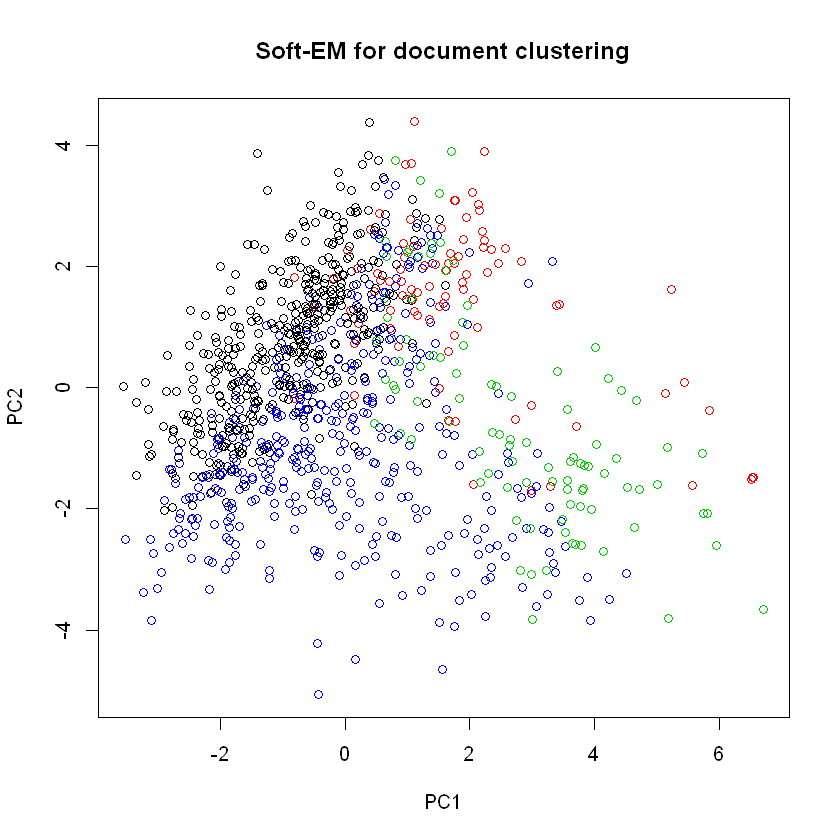

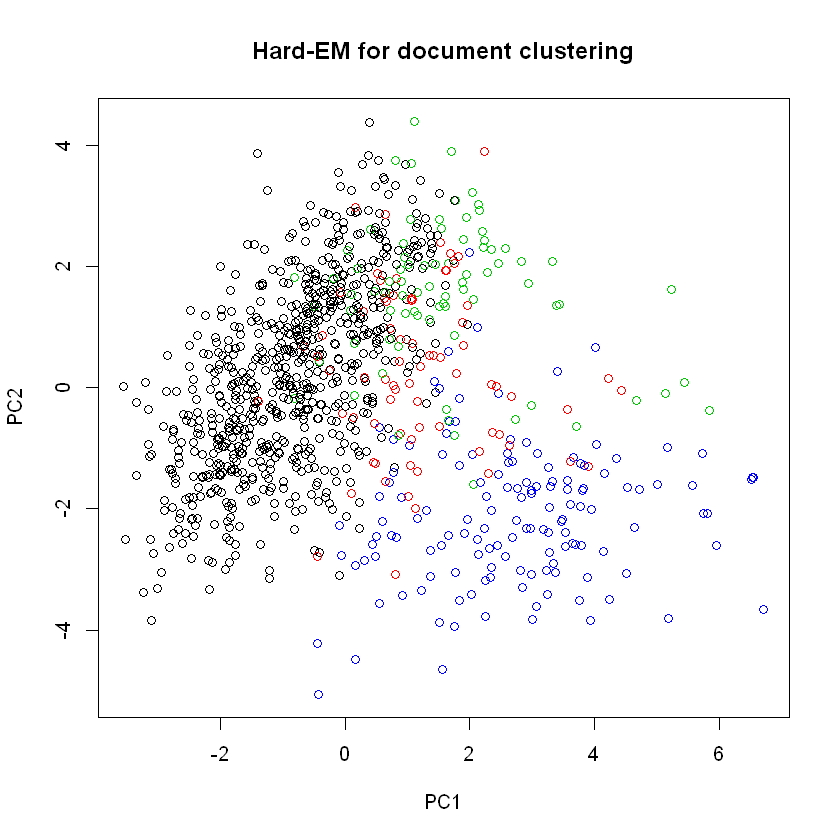

In [12]:
## visualize the Hard and Soft EM
cluster.viz(t(counts), label_soft_em, 'Soft-EM for document clustering')
cluster.viz(t(counts), label_hard_em, 'Hard-EM for document clustering')

## Reference

All the code and implementation is derieved from the following sources:


- Haffari, G. & Kazimipour, B. (2016, July). $\textit{codeBase2A.R}$. https://lms.monash.edu/pluginfile.php/14028238/mod_assign/intro/Dataset%20and%20Sample%20code_2022.zip

- Jupyter Notebooks:FIT5201 Machine Learning, (nd.). $\textit{Activity 4.1. EM for GMM}$. 
https://lms.monash.edu/mod/folder/view.php?id=10172219

- Jupyter Notebooks:FIT5201 Machine Learning, (nd.). $\textit{Activity 4.2. Document Clustering}$. 
https://lms.monash.edu/mod/folder/view.php?id=10172219

- Zhuang, B. (2022a). $\textit{Week 7.: Module 4 - A | Latent Variable Models}$ \[PowerPoint slides]. https://lms.monash.edu/mod/resource/view.php?id=9895015

- Zhuang, B. (2022b). $\textit{Week 8.: Module 4 - B | Latent Variable Models}$ \[PowerPoint slides]. https://lms.monash.edu/mod/resource/view.php?id=9895032
